# Spatial Projections

And now the time has come to discuss projections and Coordinate Reference Systems -- perhaps the most subtle, slippery, but important topic in geospatial analysis! 

## The Problem

Suppose that I gave you a tennis ball and a knife and asked you to cut the tennis ball so that it lies completely flat on the table. What would you do? 

(Seriously. Stop for a minute and think about that before proceeding. I'll wait.)

What I just asked you to do is precisely the problem that GIS analysts face any time they try to work with two-dimensional maps. The Earth is round, but we not only plot our data in two dimensions, but we usually also analyze it in two dimensions (remember how we've been representing our geometric shapes with just x-y coordinates?). So... how are we moving from three dimensions to two? 

At first, this may seem easy given we only care about the *surface* of the Earth, which feels two-dimensional. But as you probably just realized in thinking about the tennis ball example, converting a curved surface into a flat surface actually isn't trivial. In fact, there's no way to get a tennis ball to lay perfectly flat just by cutting it -- in the end, you'd **have** to stretch the ball some to get it flat on the table.

This process of flattening a three-dimensional surface into two-dimensions is what we call *projecting your data*. And projecting data turns out to be complicated because there are lots of different ways to project your surface from three dimensions down into two, and each approach will result in the surface stretching in different ways. 

## The Projection Impossibility Theory

It turns out that when we project the Earth into two dimensions, we can only ever perfectly preserve *two* of the following *three* properties of the real world:

- **Area** within polygons
- **Distance** between points
- **Shape** (or, more technically, the angles between intersecting lines)

And so because there's no way to get a 2-D projection of the world that perfectly preserves all three of these features, GIS professionals have developed *hundreds* of different projections that strike different balances in how distortions are distributed across these different attributes of a map. 

To be clear, we can only *perfectly* preserve two of these three, but we can trade off our distortions across these three properties continuously. For example, one projection may try and minimize distortions across all three evenly, distorting each a little, but offering a representation of the world that's reasonable across all three dimensions. Such a projection may be good for a general purpose map. But another may prioritize preservation of distances and evenly distribute the residual distortion over the other two. That would be a good projection for analyzing travel distances.

But projections don't just balance the distribution of distortions across these properties globally -- they can also distribute distortions differentially across space. A projection optimized for North America, for example, may minimize distortions for North America by accepting greater distortions in Canada and Mexico.

It is for this reason that there is no "right" or "correct" projection that can be used universally. Which projection is most appropriate will always depend on the application, and so it is up to *you*, the GIS professional, to understand the trade-offs one is imposing on your data when you pick a projection.



## Projection Examples

OK, that all feels pretty abstract. Let's be more concrete, starting by plotting our `world` GeoDataFrame map in a few common projections!

To begin, let's see what we get if we treat longitude as our x-coordinates and latitude as our y-coordinates. This is referred to as a Plate-Carrée projection, and... you should never use it! It has basically no desirable properties. :)

In [15]:
import geopandas as gpd

world = gpd.read_file(
    "https://github.com/nickeubank/practicaldatascience_book/raw/refs"
    "/heads/main/notebooks/gis/example_data/world_countries/world_countries.geojson"
).to_crs(epsg=4326)

/users/nce8/miniforge3/envs/geo/lib/python3.13/site-packages/shapely/constructive.py:829: RuntimeWarning: invalid value encountered in normalize
  return lib.normalize(geometry, **kwargs)
/users/nce8/miniforge3/envs/geo/lib/python3.13/site-packages/shapely/constructive.py:829: RuntimeWarning: invalid value encountered in normalize
  return lib.normalize(geometry, **kwargs)


<Axes: >

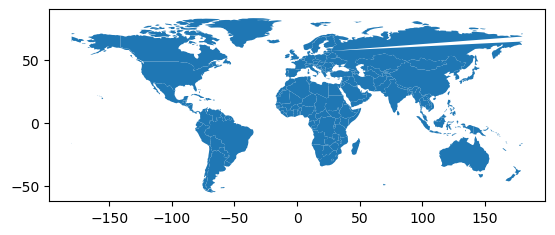

In [18]:
world_minus_antartica.plot(aspect=1)

Basically, treating latitudes and longitudes as x-y coordinates leads to shapes that are reasonable in terms of their vertical shape. Because longitude lines all converge at the North and South poles, though, forcing these to be regularly spaced in our flat x-y plane means that everything is being stretched horizontally as you move towards the poles.

Our next projection is Web Mercator, the de facto standard projection for services like google maps. Mercator projections is what you would get if you put a cylinder of paper around a transparent globe, put a light in the middle of the Earth, and then traced the shadow it cast on the paper:

![Mercator as Light](images/Usgs_map_mercator.webp)
(Source: USGS)


As you'll see, it's reasonable for middle latitudes, but really, *really* distorts the size of things in the extreme latitudes (e.g. Iceland).

/users/nce8/miniforge3/envs/geo/lib/python3.13/site-packages/shapely/constructive.py:829: RuntimeWarning: invalid value encountered in normalize
  return lib.normalize(geometry, **kwargs)
/users/nce8/miniforge3/envs/geo/lib/python3.13/site-packages/shapely/constructive.py:829: RuntimeWarning: invalid value encountered in normalize
  return lib.normalize(geometry, **kwargs)


<Axes: >

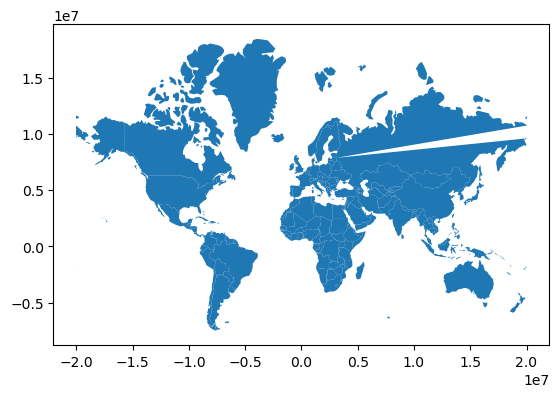

In [19]:
# Doesn't work for Antarctica
world = world[world.name != "Antarctica"]

# Here we're using to_crs()
# to re-project our data. EPSG is an
# organization that has a bunch of standard
# projections, so here I'm telling geopandas
# to use their web mercator.
# we'll talk about how to find these later.

world.to_crs(epsg=3857).plot()

How much is this distorting the size of extreme latitudes? Here a gif from Wikipedia that rescales countries to be "accurately sized" (i.e. correct area, albeit at the expense of location):

![Animated Mercator GIF](https://upload.wikimedia.org/wikipedia/commons/e/ee/Worlds_animate.gif)

And you can also see a fun interactive tool that helps illustrate these size [distortions here](https://thetruesize.com/).

Want some more? No good lesson would be complete without an XKCD cartoon, so here's a great one:

![xkcd projections](https://imgs.xkcd.com/comics/map_projections.png)

## Interactive Projection Tools

The final thing I'd suggest to get a sense of how projections work is to check out [this site by Ian Johnson](https://bl.ocks.org/enjalot/bd552e711b8325c64729), [WolframAlpha](https://demonstrations.wolfram.com/WorldMapProjections/).



## Do I Have to Work in Two-Dimensions?

We've talked a lot about the challenge of working in two dimensions, which raises the question: why not just stay in three-dimensions?

There are settings in which people use three-dimensional models of the Earth for GIS analysis. Airlines, for example, estimate flight distances across a sphere using what are called "great circle" / "geodesic" distances. There's just no single projection that will do a good enjoy job of modeling the Earth at the scale they work, and measuring distances between points on a three-dimensional model is relatively straightforward, especially when they're through the air. 

But other geometric operations get *very* slippery once we move to a three-dimensional model. For example, the distance between two points is just $\sqrt{x^2 + y^2}$ in two dimensions. In three dimensions, we'd first have to define the contour of the surface over which we're traveling (is the Earth a sphere in this model? Or do we have elevation?), then measure the distance over that contour. 

So no, it's not strictly necessary. But life in 2-D is much easier. 


## Working with Projections

OK, now that we have some sense of what projections *are*, it's time to learn about [how they're represented, manipulated, and converted in geopandas!](gis_crs_in_geopandas.ipynb)